# Optimization Methods

Build a classifier to separate blue dots from red dots.We will try the same model with 3 different optimization algorithms:

- Gradient descent
- Momentum
- Adam

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils_v1a import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils_v1a import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 1 - Gradient Descent

In [2]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(parameters) // 2 # number of layers in the neural networks

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

## 2 - Mini-Batch Gradient Descent

In [9]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape(1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini-batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    # Step 2: Partition (shuffled_X, shuffled_Y)
    num_complete_minibatches = m // mini_batch_size
    for k in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size :]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

## 3 - Momentum

In [15]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2
    v = {}
    
    for i in range(1, L + 1):
        W = parameters['W' + str(i)]
        b = parameters['b' + str(i)]
        v['dW' + str(i)] = np.zeros((W.shape[0], W.shape[1]))
        v['db' + str(i)] = np.zeros((b.shape[0], b.shape[1]))
    
    return v

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}$$

In [17]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """
    
    L = len(parameters) // 2
    for i in range(1, L + 1):
        v['dW' + str(i)] = beta * v['dW' + str(i)] + (1 - beta) * grads['dW' + str(i)]
        v['db' + str(i)] = beta * v['db' + str(i)] + (1 - beta) * grads['db' + str(i)]
        parameters['W' + str(i)] = parameters['W' + str(i)] - learning_rate * v['dW' + str(i)]
        parameters['b' + str(i)] = parameters['b' + str(i)] - learning_rate * v['db' + str(i)]
    
    return parameters, v

## 4 - Adam

In [19]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    v = {}
    s = {}
    L = len(parameters) // 2
    for i in range(1, L + 1):
        W = parameters['W' + str(i)]
        b = parameters['b' + str(i)]
        v["dW" + str(i)] = np.zeros((W.shape[0], W.shape[1]))
        v['db' + str(i)] = np.zeros((b.shape[0], b.shape[1]))
        s["dW" + str(i)] = np.zeros((W.shape[0], W.shape[1]))
        s['db' + str(i)] = np.zeros((b.shape[0], b.shape[1]))
    
    return v, s

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$

In [24]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}
    
    for i in range(1, L + 1):
        v['dW' + str(i)] = beta1 * v['dW' + str(i)] + (1 - beta1) * grads['dW' + str(i)]
        v['db' + str(i)] = beta1 * v['db' + str(i)] + (1 - beta1) * grads['db' + str(i)]
        s['dW' + str(i)] = beta2 * s['dW' + str(i)] + (1 - beta2) * np.square(grads['dW' + str(i)])
        s['db' + str(i)] = beta2 * s['db' + str(i)] + (1 - beta2) * np.square(grads['db' + str(i)])
        v_corrected['dW' + str(i)] = v['dW' + str(i)] / (1 - beta1 ** t)
        v_corrected['db' + str(i)] = v['db' + str(i)] / (1 - beta1 ** t)
        s_corrected['dW' + str(i)] = s['dW' + str(i)] / (1 - beta2 ** t)
        s_corrected['db' + str(i)] = s['db' + str(i)] / (1 - beta2 ** t)
        
        parameters['W' + str(i)] -= learning_rate *  v_corrected['dW' + str(i)] / (np.sqrt(s_corrected['dW' + str(i)] + epsilon))
        parameters['b' + str(i)] -= learning_rate *  v_corrected['db' + str(i)] / (np.sqrt(s_corrected['db' + str(i)] + epsilon))
    
    return parameters, v, s

## 5 - Model with different optimization algorithms

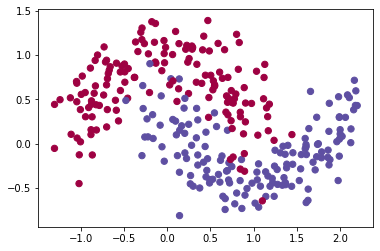

In [26]:
train_X, train_Y = load_dataset()

In [39]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    
    L = len(layers_dims) - 1
    costs = []
    t = 0
    seed = 10
    m = X.shape[1]
    
    parameters = initialize_parameters(layers_dims)
    
    if optimizer == 'gd':
        pass
    elif optimizer == 'momentum':
        v = initialize_velocity(parameters)
    elif optimizer == 'adam':
        v, s = initialize_adam(parameters)
    
    for i in range(num_epochs):
        seed += 1
        mini_batches = random_mini_batches(X, Y, mini_batch_size, seed = seed)
        cost_total = 0
        
        for (minibatch_X, minibatch_Y) in mini_batches:
            a3, caches = forward_propagation(minibatch_X, parameters)
            cost_total += compute_cost(a3, minibatch_Y)
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)
            if optimizer == 'gd':
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == 'momentum':
                parameters, s = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == 'adam':
                t += 1
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate)
        
        cost_avg = cost_total / m
    
        if print_cost and i % 1000 == 0:
            print('Cost after epoch %i: %f' %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
        
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

### 5.1 - Mini-batch gradient descent

Cost after epoch 0: 0.702405
Cost after epoch 1000: 0.668101
Cost after epoch 2000: 0.635288
Cost after epoch 3000: 0.600491
Cost after epoch 4000: 0.573367
Cost after epoch 5000: 0.551977
Cost after epoch 6000: 0.532370
Cost after epoch 7000: 0.514007
Cost after epoch 8000: 0.496472
Cost after epoch 9000: 0.468014


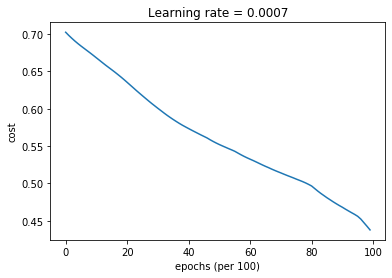

Accuracy: 0.7966666666666666


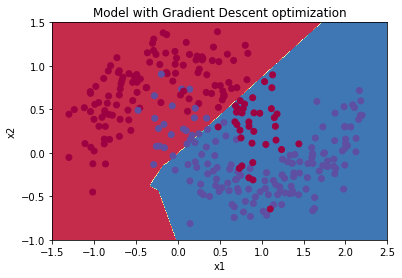

In [37]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y[0])

### 5.2 - Mini-batch gradient descent with momentum

Cost after epoch 0: 0.702413
Cost after epoch 1000: 0.668167
Cost after epoch 2000: 0.635388
Cost after epoch 3000: 0.600591
Cost after epoch 4000: 0.573444
Cost after epoch 5000: 0.552058
Cost after epoch 6000: 0.532458
Cost after epoch 7000: 0.514101
Cost after epoch 8000: 0.496652
Cost after epoch 9000: 0.468160


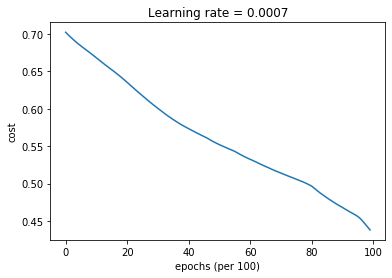

Accuracy: 0.7966666666666666


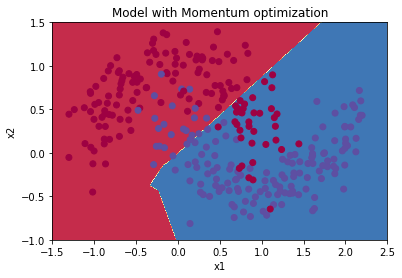

In [41]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y[0])

### 5.3 - Mini-batch gradient descent with Adam mode

Cost after epoch 0: 0.702166
Cost after epoch 1000: 0.167966
Cost after epoch 2000: 0.141320
Cost after epoch 3000: 0.138782
Cost after epoch 4000: 0.136111
Cost after epoch 5000: 0.134327
Cost after epoch 6000: 0.131147
Cost after epoch 7000: 0.130245
Cost after epoch 8000: 0.129655
Cost after epoch 9000: 0.129159


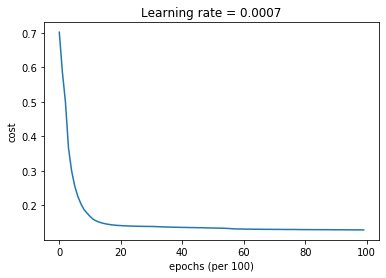

Accuracy: 0.94


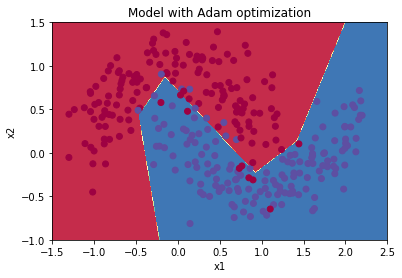

In [43]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y[0])

## 6 - Summary

Optimization method | Accuracy | Cost shape | 
:-: | :-: | :-: | 
Gradient descent | 79.7% | Oscillations | 
Momentum | 79.7% | Oscillations | 
Adam | 94% | Smoother | 